In [1]:
# %matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
# locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

# from datetime import date
import datetime


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [2]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [47]:
# Start by getting the most recent data

for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        mostRecentTuesday = dayToCheck
        tuePath = 'SSI_data_'+str(dayToCheck)

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

df_case_recent = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df_dea_recent = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_dode.csv',delimiter=';')


Path to latest Tuesday was SSI_data_2022-03-15


In [54]:
# Go through each tuesday, as long back as possible, and grab the last columns

df_case  = df_case_recent.copy()
df_dea = df_dea_recent.copy()

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_cases.csv'
    if os.path.exists(filePath):
        cur_df_case = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_dode.csv'
    if os.path.exists(filePath):
        cur_df_dea = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    

    # For now, only go back until registration style changed 
    if (cur_df_case.shape == df_case_recent.shape):
        # df_case
        allCols= [x[7:11]+x[4:6] for x in cur_df_case.columns]
        oldestIndex = np.argsort(allCols)[0]
        # print(np.argsort(allCols)[0])
        # print(cur_df_case.columns[oldestIndex-4])
        toAppend = cur_df_case.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_I = cur_df_dea.iloc[:,oldestIndex-4:oldestIndex+1]

        df_case = df_case.join(toAppend)
        df_dea = df_dea.join(toAppend_I)

        # print(np.sort(allCols)[0])
# cur_df_case
# df_case

In [59]:

sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'

allS = [sNone,sOne,sTwo,sFull,sReva] 

posWeekNames = np.unique([x[:11] for x in df_case.columns[1:]])
weekOrder = np.argsort([x[-4:] + x[4:6] for x in posWeekNames])
allWeekNames = posWeekNames[weekOrder]

        

curDTs= [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in allWeekNames]


In [60]:
# Make function for getting particular parts

def getTimeSeries(thisdf=df_case,curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df_case,curAge='Alle',weekNames=allWeekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

getTimeSeriesAll(df_dea)

array([  8,   8,  13,   9,  23,  17,  17,  15,  10,  16,   9,  18,  25,
        33,  38,  76,  67,  66,  76,  86,  68, 106, 106, 111, 136, 145,
       209, 224, 275, 291, 253], dtype=int64)

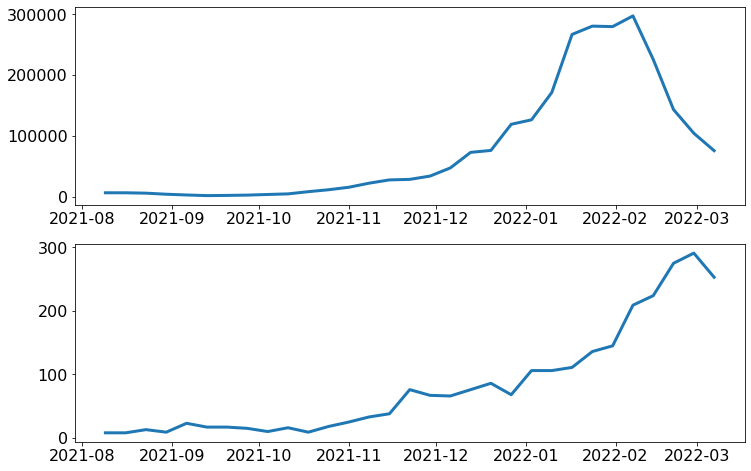

In [61]:
fig,(ax1,ax2) = plt.subplots(2,1)

ax1.plot(curDTs,getTimeSeriesAll(df_case))
ax2.plot(curDTs,getTimeSeriesAll(df_dea))

In [62]:
allAges = df_case.Aldersgruppe.values

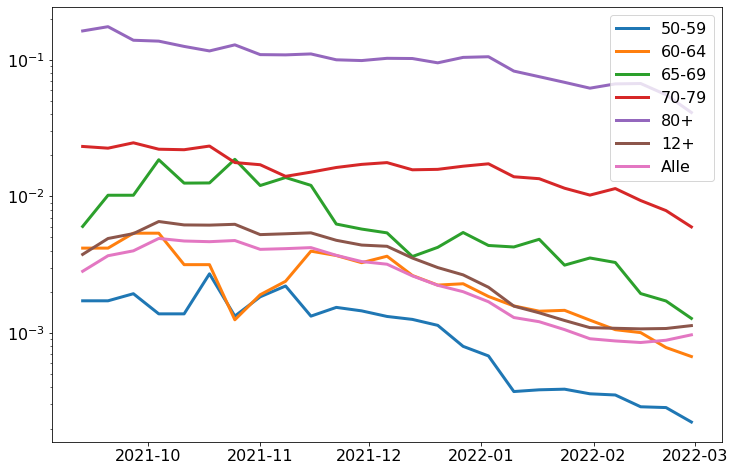

In [66]:
curAge = '80+'

fig,ax1 = plt.subplots()

# curMin = 0.0000001

# for curAge in allAges[-7:-2]:
# for curAge in allAges[:-2]:
# for curAge in allAges[4:-2]:
for curAge in allAges[-7:]:
    curCase = getTimeSeriesAll(df_case,curAge=curAge)
    curDea = getTimeSeriesAll(df_dea,curAge=curAge)

    curCFR = curDea[3:]/curCase[:-3]

    # ax1.plot(curDTs[3:],curCFR,label=curAge)
    # ax1.plot(curDTs[3:],curCFR + curMin,label=curAge)
    ax1.plot(pf.rnTime(curDTs[3:],4),pf.rnMean(curCFR,4),label=curAge)

ax1.set_yscale('log')
# ax1.set_ylim(bottom=0.001)
ax1.legend()